In [100]:
import pandas as pd
import pickle
import numpy as np
from scipy.stats import pearsonr
from tqdm.notebook import tqdm, tqdm_notebook
import json
import seaborn as sns
import os
import matplotlib.pyplot as plt
sns.set()

### Definitions

In [101]:
def cache(path, f):
    if not os.path.exists(path):
        result = f()
        json.dump(result, open(path, 'wt'))
        return result
    else:
        return json.load(open(path))

In [102]:
def generate(xs, df, true_means, trials=1000, group_name='system', score_name='score', ratio=-1):
    # need to make sure all systems have about the same # of ex
    # need to make sure that ratio is not very large
    groups = df.groupby(group_name, as_index=False)
    
    ys = []
    for x in tqdm(xs):
        x = int(x * ratio) if ratio > 1 else x
        data = []
        for i in range(0, trials):
            simulated_test_set = groups.apply(lambda g: g.sample(n=x, replace=True).mean())
            means = simulated_test_set[score_name]
            r = pearsonr(means, true_means)[0]
            data.append(r)
        ys.append((np.mean(data), np.median(data), np.percentile(data, 0.05), np.percentile(data, 0.95)))
    
    return ys

# Analysis

### Human scores

In [29]:
wmt19 = pickle.load(open('../wmt16-19-metrics-shared-task/wmt_metadata/pickles/wmt19_sys_metadata.pkl', 'rb'))
wmt19.lp.value_counts()

ru-en    34726
fi-en    29144
lt-en    23481
kk-en    22915
gu-en    21454
zh-en    20199
de-cs    16900
de-fr     6700
fr-de     4000
Name: lp, dtype: int64

In [30]:
pooled_vars_toen = json.load(open('./data/vars/pooled_vars_toen.json'))
total_vars_toen = json.load(open('./data/vars/total_vars_toen.json'))

In [31]:
pooled_var, total_var = pooled_vars_toen['wmt19'], total_vars_toen['wmt19']
true_var = total_var - pooled_var
ratio = total_var / true_var

print(ratio)     # using x(ratio) more data is theoretical.

2.2356780848518056


### Metric scores

In [33]:
metric_scores = pd.read_csv('./indexes.tsv', sep='\t', index_col=[0])
read_scores = lambda x: [ float(i.strip()) for i in list(open(x)) ]
metric_scores['sentbleu'] = read_scores('./sentbleu_scores')
metric_scores['bleurt'] = read_scores('./bleurt-base-128_scores')
metric_scores['bleurt'] = read_scores('./bleurt-base-128_scores')
metric_scores['bert_score'] = [ float(i.split('\t')[2]) for i in list(open('./score_bert-score'))[1:]]

### WMT2019 (*-en)

fi-en



gu-en



ru-en



lt-en



kk-en



zh-en


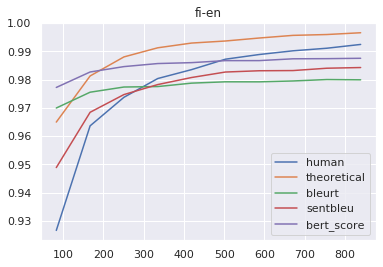

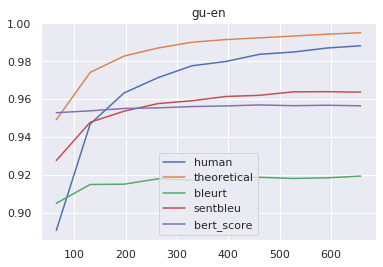

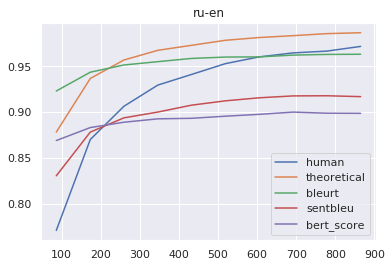

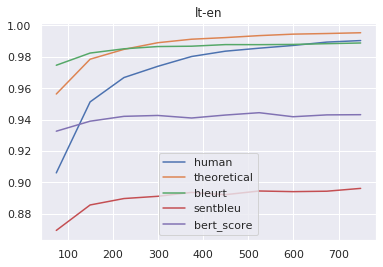

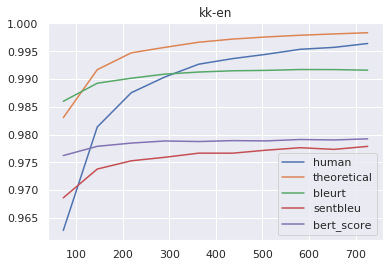

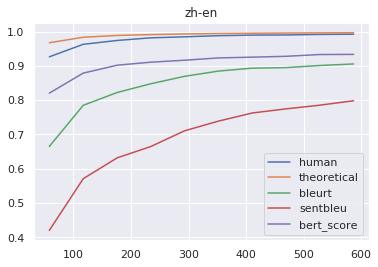

In [99]:
TRIALS=300
all_ys = {}
for lp in wmt19.lp.unique():
    if not lp.endswith('en'):
        continue

    print(lp)
    df_lp =  wmt19[(wmt19.lp == lp) & (wmt19.type.isin(['SYSTEM', 'REPEAT']))]
    true = [ group.mean()['score'] for i, group in df_lp.groupby('system') ]
    xs = np.linspace(df_lp.groupby('system').count().min()['score'] / ratio, 0, 10, endpoint=False).astype(int)

    ys = {}
    try:
        os.makedirs('cache/%s' % lp)
    except:
        pass
    
    ys['human'] = cache('cache/%s/y_human.json' % lp, lambda : generate(xs, df_lp[['system', 'score']], true, trials=TRIALS))
    ys['theoretical'] = cache('cache/%s/y_theoretical.json' % lp, lambda : generate(xs, df_lp[['system', 'score']], true, trials=TRIALS, ratio=ratio))

    metric_scores_lp = metric_scores[metric_scores.lp == lp]
    ys['bleurt'] = cache('cache/%s/y_bleurt.json' % lp, lambda : generate(xs, metric_scores_lp[['system', 'bleurt']], true, score_name='bleurt', trials=TRIALS))
    ys['sentbleu'] = cache('cache/%s/y_sentbleu.json' % lp, lambda : generate(xs, metric_scores_lp[['system', 'sentbleu']], true, score_name='sentbleu', trials=TRIALS))
    ys['bert_score'] = cache('cache/%s/y_bert_score.json'% lp, lambda : generate(xs, metric_scores_lp[['system', 'bert_score']], true, score_name='bert_score', trials=TRIALS))
    
    plt.figure()
    plt.title(lp)
    for k, v in ys.items():
        sns.lineplot(x=xs, y=[i[0] for i in v], label=k)
    plt.savefig('figs/%s.png' % lp)